# <font color=#025dfa> Probabilistik Zaman Serisi ile Sıcaklık Tahmini: Derin Öğrenme Yaklaşımı - Temperature Forecasting with Probabilistic Time Series: A Deep Learning Approach

TR = Her yorum satırı kendisini üstündeki koda aittir. İlk olarak Türkçe, son olarak İngilizce yazıldı.

EN = Each comment line belongs to the code above it. It was first written in Turkish and lastly in English.

TR = Bu proje, sıcaklık tahmini için probabilistik zaman serisi analizini derin öğrenme yöntemleriyle birleştirmeyi amaçlamaktadır. Kaggle’ın "Probabilistic Forecasting I - Temperature" yarışmasından alınan sıcaklık verisetini kullanarak, gelecekteki sıcaklık değişimlerini daha kesin bir şekilde tahmin edebilecek bir model geliştirilecektir. Proje, çeşitli hava durumu parametrelerini dikkate alarak, probabilistik yaklaşımla farklı tahmin senaryolarını değerlendirecek ve daha güvenilir sıcaklık tahminleri sunarak meteorolojik analiz ve planlamalara katkı sağlamayı hedeflemektedir.

EN = This project aims to combine probabilistic time series analysis with deep learning methods for temperature forecasting. Using the temperature dataset from Kaggle’s “Probabilistic Forecasting I - Temperature” competition, a model will be developed that can predict future temperature changes more precisely. The project aims to contribute to meteorological analysis and planning by evaluating different forecast scenarios with a probabilistic approach, taking into account various weather parameters, and providing more reliable temperature forecasts.

Kaynak/Source = https://www.kaggle.com/competitions/probabilistic-forecasting-i-temperature

In [1]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
import nltk
import plotly.express as px
import math
import pickle
import warnings
warnings.filterwarnings('ignore')
import re

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler ,MinMaxScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Flatten, Dropout, BatchNormalization, LeakyReLU
from tensorflow.keras.callbacks import EarlyStopping
from sklearn.metrics import r2_score, mean_squared_error, mean_absolute_error
from prophet import Prophet
from prophet.plot import plot_plotly,plot_components_plotly

In [2]:
pd.set_option("display.max_columns",None) 
# TR = En fazla kaç sütun olduğunu gösteriyor. 
# EN = It shows the maximum number of columns.

In [3]:
df=pd.read_csv('train.csv')

## <font color=#FFD700> EDA Keşif Amaçlı Veri Analizi - EDA - Exploratory Data Analysis 

In [4]:
df.head()

,id,date,feature_AA,feature_AB,feature_BA,feature_BB,feature_CA,feature_CB,Temperature
0,0,2016-07-01 00:00:00,5.827,2.009,1.599,0.462,4.203,1.340,30.531000
1,1,2016-07-01 00:15:00,5.760,2.076,1.492,0.426,4.264,1.401,30.459999
2,2,2016-07-01 00:30:00,5.760,1.942,1.492,0.391,4.234,1.310,30.038000
3,3,2016-07-01 00:45:00,5.760,1.942,1.492,0.426,4.234,1.310,27.013000
4,4,2016-07-01 01:00:00,5.693,2.076,1.492,0.426,4.142,1.371,27.787001


In [5]:
df.sample(5)

,id,date,feature_AA,feature_AB,feature_BA,feature_BB,feature_CA,feature_CB,Temperature
6293,6293,2016-09-04 13:15:00,7.502,3.215,5.010,1.812,2.528,1.157,28.702000
780,780,2016-07-09 03:00:00,13.999,6.497,10.945,3.198,2.711,1.675,28.702000
48813,48813,2017-11-21 11:15:00,1.273,2.813,-1.883,1.102,3.564,1.401,4.291000
17525,17525,2016-12-30 13:15:00,8.105,0.402,5.224,-1.564,2.924,1.432,11.326000
4004,4004,2016-08-11 17:00:00,11.454,5.023,7.285,3.020,4.264,1.462,35.313999


In [6]:
df.tail()

,id,date,feature_AA,feature_AB,feature_BA,feature_BB,feature_CA,feature_CB,Temperature
64315,64315,2018-05-01 22:45:00,12.458,1.407,7.889,-0.746,4.843,1.523,10.622
64316,64316,2018-05-01 23:00:00,14.200,1.541,9.310,0.284,4.752,1.249,10.482
64317,64317,2018-05-01 23:15:00,12.659,1.474,7.924,-0.959,4.569,1.310,10.271
64318,64318,2018-05-01 23:30:00,13.329,1.541,8.671,-0.533,4.630,1.371,10.341
64319,64319,2018-05-01 23:45:00,11.588,0.871,7.214,-0.426,4.691,1.310,10.833


In [7]:
df.shape

(64320, 9)

In [8]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 64320 entries, 0 to 64319
Data columns (total 9 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   id           64320 non-null  int64  
 1   date         64320 non-null  object 
 2   feature_AA   64320 non-null  float64
 3   feature_AB   64320 non-null  float64
 4   feature_BA   64320 non-null  float64
 5   feature_BB   64320 non-null  float64
 6   feature_CA   64320 non-null  float64
 7   feature_CB   64320 non-null  float64
 8   Temperature  64320 non-null  float64
dtypes: float64(7), int64(1), object(1)
memory usage: 4.4+ MB


In [9]:
df.isnull().sum().sort_values(ascending=False)

id             0
date           0
feature_AA     0
feature_AB     0
feature_BA     0
feature_BB     0
feature_CA     0
feature_CB     0
Temperature    0
dtype: int64

In [10]:
df.describe()

,id,feature_AA,feature_AB,feature_BA,feature_BB,feature_CA,feature_CB,Temperature
count,64320.000000,64320.000000,64320.000000,64320.000000,64320.000000,64320.000000,64320.000000,64320.000000
mean,32159.500000,7.522545,2.142897,4.478698,0.820356,3.042537,0.819362,13.610430
std,18567.728994,6.914888,2.023449,6.669074,1.818778,1.169700,0.602287,8.827735
min,0.000000,-21.568001,-5.693000,-23.986000,-6.041000,-1.188000,-1.371000,-4.221000
25%,16079.750000,5.961000,0.670000,3.553000,-0.391000,2.284000,0.640000,6.753000
50%,32159.500000,8.841000,2.076000,6.041000,0.853000,2.802000,0.944000,11.959000
75%,48239.250000,11.721000,3.550000,8.635000,2.132000,3.594000,1.157000,18.712000
max,64319.000000,24.180000,10.315000,18.087000,7.853000,8.498000,3.046000,46.007000


In [11]:
df.corr(numeric_only=True)

,id,feature_AA,feature_AB,feature_BA,feature_BB,feature_CA,feature_CB,Temperature
id,1.000000,-0.171862,-0.069078,-0.195561,-0.079652,0.119695,0.027805,-0.648064
feature_AA,-0.171862,1.000000,0.119506,0.986868,0.061591,0.290872,0.040617,0.064954
feature_AB,-0.069078,0.119506,1.000000,0.078182,0.929007,0.231256,0.344268,0.262743
feature_BA,-0.195561,0.986868,0.078182,1.000000,0.046250,0.177148,-0.026984,0.051940
feature_BB,-0.079652,0.061591,0.929007,0.046250,1.000000,0.102385,0.027066,0.247977
feature_CA,0.119695,0.290872,0.231256,0.177148,0.102385,1.000000,0.313189,0.141227
feature_CB,0.027805,0.040617,0.344268,-0.026984,0.027066,0.313189,1.000000,0.097044
Temperature,-0.648064,0.064954,0.262743,0.051940,0.247977,0.141227,0.097044,1.000000


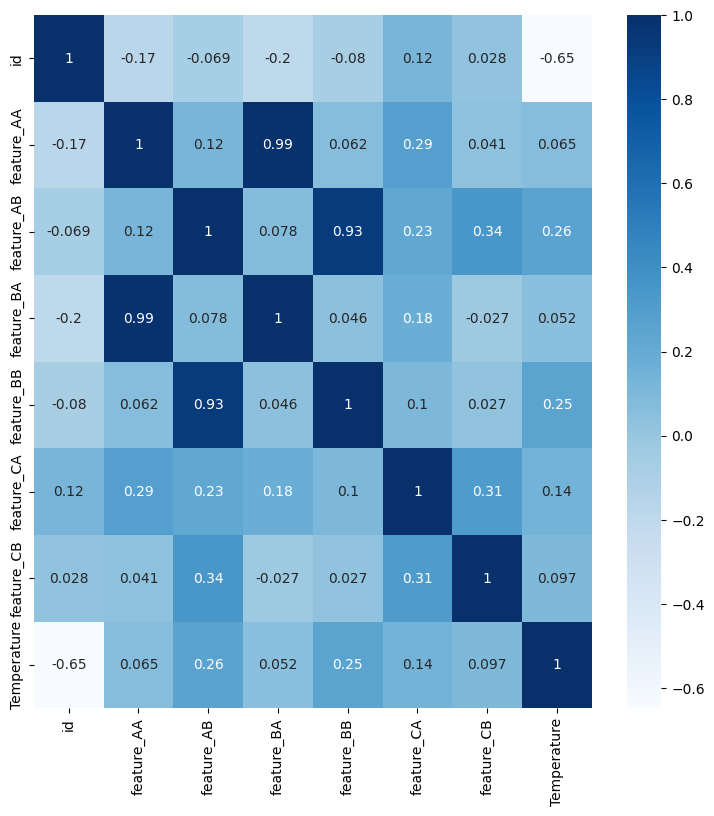

In [12]:
plt.figure(figsize=(9,9))
sns.heatmap(df.corr(numeric_only=True),annot=True,cmap='Blues');

In [13]:
abs(df.corr(numeric_only=True)['Temperature']).sort_values(ascending=False)

Temperature    1.000000
id             0.648064
feature_AB     0.262743
feature_BB     0.247977
feature_CA     0.141227
feature_CB     0.097044
feature_AA     0.064954
feature_BA     0.051940
Name: Temperature, dtype: float64

## <font color=#C0C0C0> Gereksiz Verileri Silme İşlemi Yapıyoruz - We Delete Unnecessary Data

In [14]:
df=df.drop('id',axis=1)
df.head(1)

,date,feature_AA,feature_AB,feature_BA,feature_BB,feature_CA,feature_CB,Temperature
0,2016-07-01 00:00:00,5.827,2.009,1.599,0.462,4.203,1.34,30.531


## <font color='#ff4d00'> Boşluk Varsa Doldurmaya, Düzeltilecek Kısım Varsa Düzeltmeye Başladık - If there is a gap, we started to fill it and if there is a part to be corrected, we started to correct it.

In [15]:
df.isnull().sum().sort_values(ascending=False)

date           0
feature_AA     0
feature_AB     0
feature_BA     0
feature_BB     0
feature_CA     0
feature_CB     0
Temperature    0
dtype: int64

### <font color=#ff2400> date Sütuna Bakıyoruz - We Look at the Column date

In [16]:
df['date']=pd.to_datetime(df['date'])
df['year']=(df['date']).dt.year
df['month']=(df['date']).dt.month
df['day']=(df['date']).dt.day
df['hour']=(df['date']).dt.hour
df['minute']=(df['date']).dt.minute
df.head(1)

,date,feature_AA,feature_AB,feature_BA,feature_BB,feature_CA,feature_CB,Temperature,year,month,day,hour,minute
0,2016-07-01,5.827,2.009,1.599,0.462,4.203,1.34,30.531,2016,7,1,0,0


In [17]:
df.isnull().sum().sort_values(ascending=False)

date           0
feature_AA     0
feature_AB     0
feature_BA     0
feature_BB     0
feature_CA     0
feature_CB     0
Temperature    0
year           0
month          0
day            0
hour           0
minute         0
dtype: int64

In [18]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 64320 entries, 0 to 64319
Data columns (total 13 columns):
 #   Column       Non-Null Count  Dtype         
---  ------       --------------  -----         
 0   date         64320 non-null  datetime64[ns]
 1   feature_AA   64320 non-null  float64       
 2   feature_AB   64320 non-null  float64       
 3   feature_BA   64320 non-null  float64       
 4   feature_BB   64320 non-null  float64       
 5   feature_CA   64320 non-null  float64       
 6   feature_CB   64320 non-null  float64       
 7   Temperature  64320 non-null  float64       
 8   year         64320 non-null  int32         
 9   month        64320 non-null  int32         
 10  day          64320 non-null  int32         
 11  hour         64320 non-null  int32         
 12  minute       64320 non-null  int32         
dtypes: datetime64[ns](1), float64(7), int32(5)
memory usage: 5.2 MB


In [19]:
#for column in df.columns:  
    # TR = Verideki her bir sütun için döngü başlatılıyor  
    # EN = Loops through each column in the dataframe

#    print(f"\nSütun: {column}")  
    # TR = Sütun ismi ekrana yazdırılıyor  
    # EN = Prints the column name

#    unique = df[column].dropna().unique()  
    # TR = NaN değerleri düşürerek benzersiz değerler elde ediliyor  
    # EN = Gets the unique values after dropping NaN values

#    if pd.api.types.is_numeric_dtype(df[column]):  
        # TR = Eğer sütundaki değerler sayısal ise, değerler sıralanıyor  
        # EN = If the column is of numeric type, the unique values are sorted
#        unique = sorted(unique)

#    print(f"Unique Değerler: {unique}")  
    # TR = Benzersiz değerler ekrana yazdırılıyor  
    # EN = Prints the unique values


## <font color=#1cfc03> Aykırı Değer - Outlier

In [20]:
int_columns = df.select_dtypes(include=['int64','int32']).columns
# TR = İnt veri türündeki sütunları alır  
# EN = Selects columns with int data type

float_columns = df.select_dtypes(include=['float64','float32']).columns
# TR = Float veri türündeki sütunları alır  
# EN = Selects columns with float data type

num_columns = df.select_dtypes(include=['int32','int64','float32','float64']).columns
# TR = İnt ve float veri türündeki sütunları alır  
# EN = Selects columns with inr and float data type

object_columns = df.select_dtypes(include=['object']).columns
# TR = Object veri türündeki sütunları alır  
# EN = Selects columns with object data type

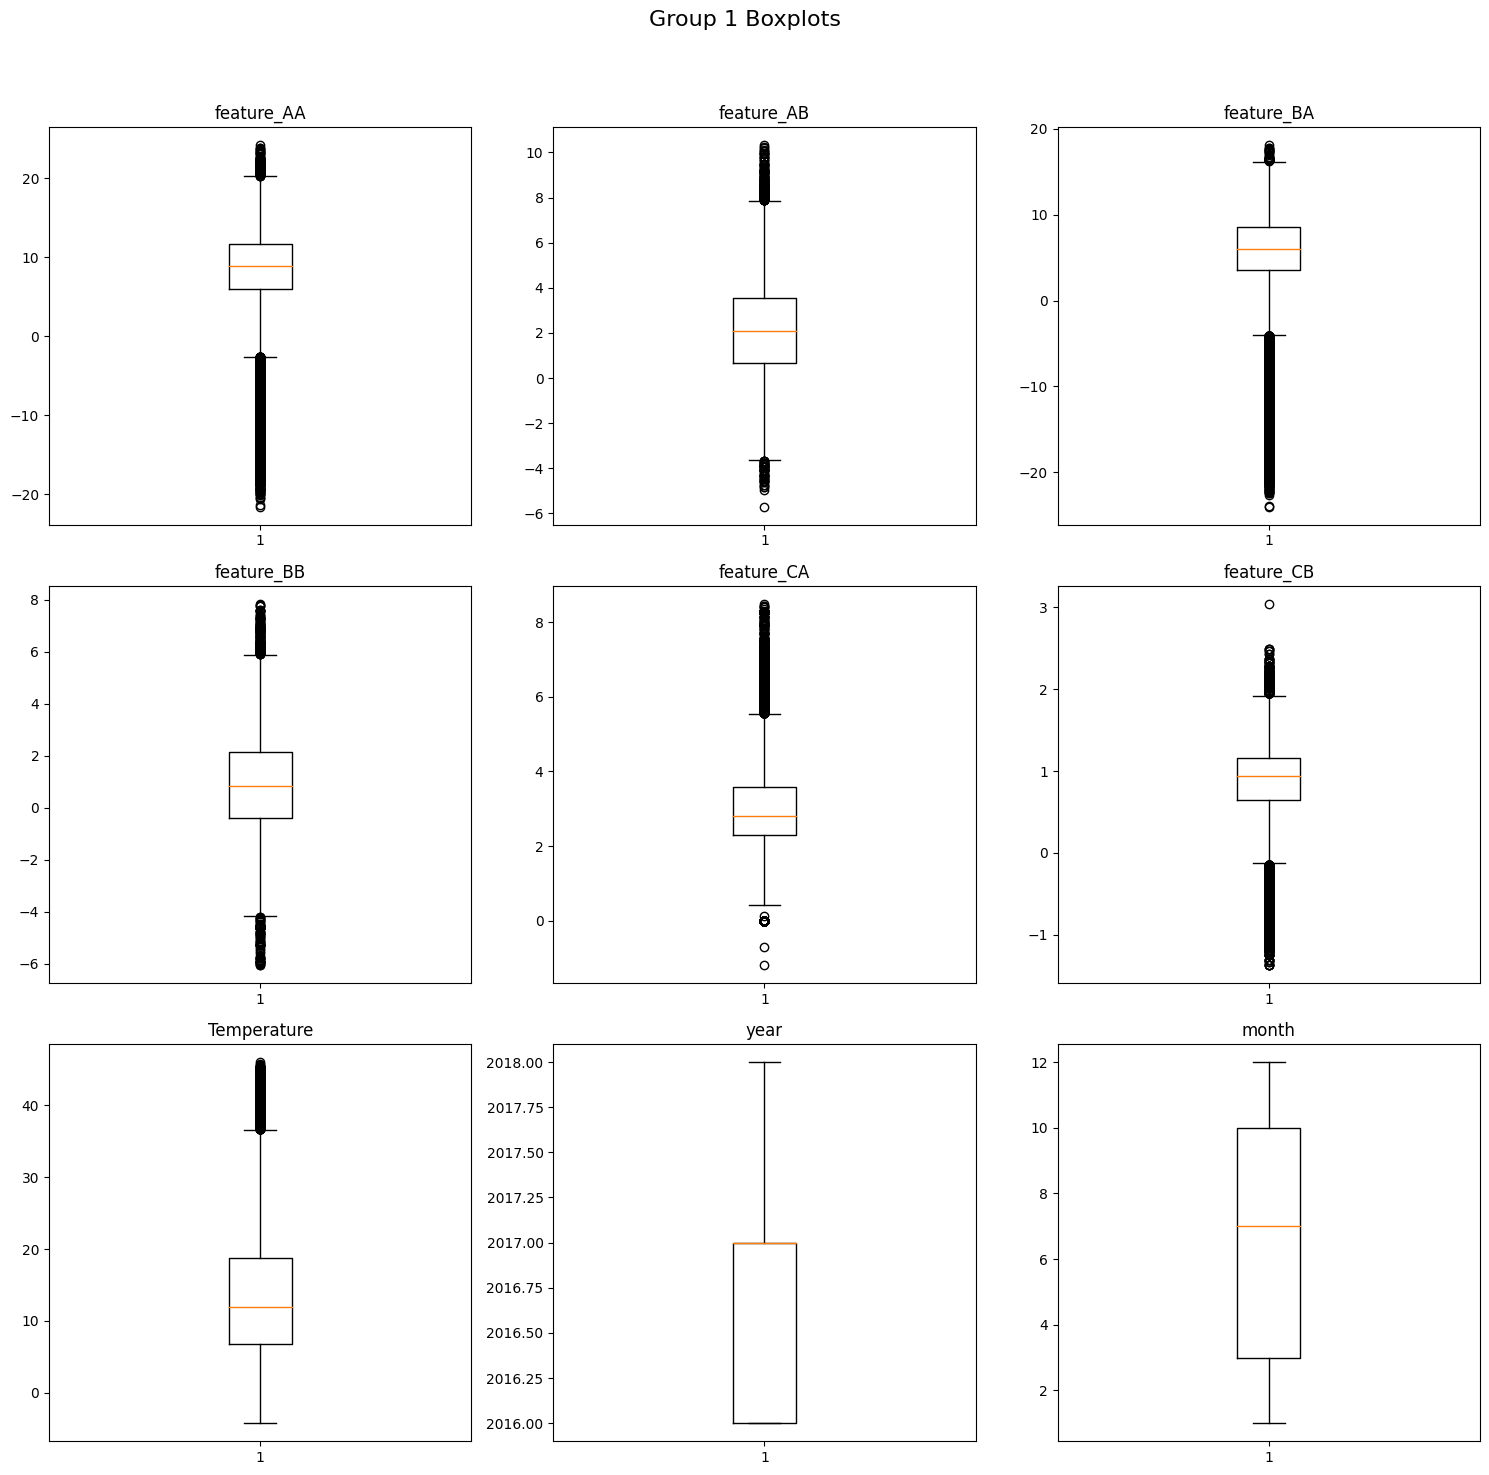

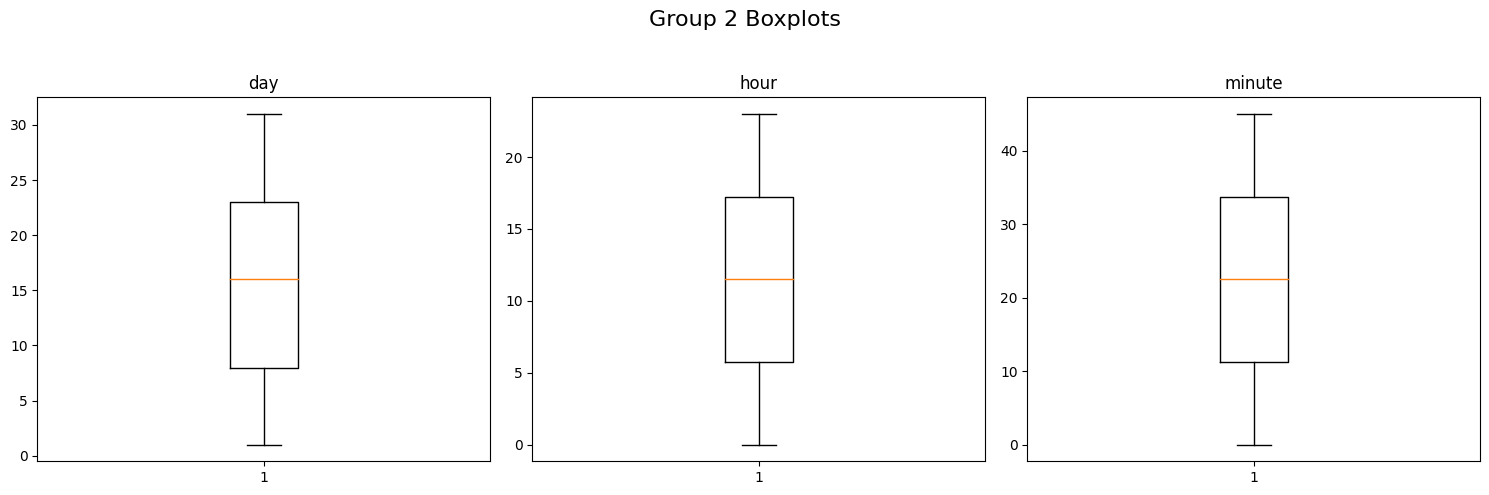

In [21]:
num_cols = len(num_columns)
# TR = Sayısal sütunların toplam sayısını hesaplar
# EN = Calculates the total number of numeric columns

num_plots_per_group = 9
# TR = Her grup için çizilecek maksimum grafik sayısını belirler
# EN = Sets the maximum number of plots per group

num_groups = math.ceil(num_cols / num_plots_per_group)
# TR = Toplam grup sayısını belirler (sütunları 9'luk gruplar halinde ayırır)
# EN = Determines the total number of groups (splits columns into groups of 9)

for group in range(num_groups):
    cols_in_group = num_columns[group * num_plots_per_group:(group + 1) * num_plots_per_group]
    # TR = O andaki grup için sütunları seçer
    # EN = Selects columns for the current group

    num_plots = len(cols_in_group)
    # TR = O andaki grup içindeki sütun sayısını hesaplar
    # EN = Calculates the number of columns in the current group

    rows = math.ceil(num_plots / 3)
    # TR = 3 sütun olacak şekilde kaç satır gerektiğini belirler
    # EN = Determines the number of rows needed for a 3-column grid

    fig, axs = plt.subplots(rows, 3, figsize=(15, 5 * rows))
    # TR = Grafikler için alt grafikler (subplots) oluşturur
    # EN = Creates subplots for the plots

    axs = axs.flatten() if num_plots > 1 else [axs]
    # TR = Kolay indeksleme için axs dizisini düzleştirir
    # EN = Flattens the axs array for easy indexing

    for i, col in enumerate(cols_in_group):
        axs[i].boxplot(df[col].dropna())
        # TR = O andaki sütunun kutu grafiğini çizdirir
        # EN = Draws a boxplot for the current column

        axs[i].set_title(col)
        # TR = Grafiğe sütun adını başlık olarak ekler
        # EN = Sets the column name as the title of the plot

    for i in range(num_plots, len(axs)):
        axs[i].set_visible(False)
        # TR = Kullanılmayan alt grafikleri gizler
        # EN = Hides unused subplots

    plt.suptitle(f'Group {group + 1} Boxplots', fontsize=16)
    # TR = Grup için genel bir başlık ekler
    # EN = Adds a general title for the group

    plt.tight_layout(rect=[0, 0, 1, 0.95])
    # TR = Grafiklerin düzenli görünmesi için yerleşim ayarlarını yapar
    # EN = Adjusts the layout for a tidy appearance

In [22]:
# TR = Aykırı değer çok fazla olduğu için işlem yapmadık. 
# EN = We did not take any action because there were too many outliers.

## <font color=#e0c510> Verileri Görşelleştirme - Visualizing Data me

In [23]:
for column in df.columns:
    # TR = Verideki her bir sütun için döngü başlatılıyor  
    # EN = Loops through each column in the dataframe

    print(f"\nSütun: {column}")  
    # TR = Sütun ismi ekrana yazdırılıyor  
    # EN = Prints the column name

    unique = df[column].dropna().unique()  
    # TR = NaN değerleri düşürerek benzersiz değerler elde ediliyor  
    # EN = Gets the unique values after dropping NaN values

    if pd.api.types.is_numeric_dtype(df[column]):  
        # TR = Eğer sütundaki değerler sayısal ise, değerler sıralanıyor  
        # EN = If the column is of numeric type, the unique values are sorted
        unique = sorted(unique)
        
    nunique = len(unique)  # Benzersiz değerlerin sayısını hesapla
    # TR = Benzersiz değerlerin sayısını hesaplar  
    # EN = Calculates the number of unique values

    print(f"Nunique Değerler: {nunique}")  
    # TR = Benzersiz değerlerin sayısını ekrana yazdırır  
    # EN = Prints the number of unique values

    print(f"Unique Değerler: {unique}")  
    # TR = Benzersiz değerler ekrana yazdırılıyor  
    # EN = Prints the unique values



Sütun: date
Nunique Değerler: 64320
Unique Değerler: <DatetimeArray>
['2016-07-01 00:00:00', '2016-07-01 00:15:00', '2016-07-01 00:30:00',
 '2016-07-01 00:45:00', '2016-07-01 01:00:00', '2016-07-01 01:15:00',
 '2016-07-01 01:30:00', '2016-07-01 01:45:00', '2016-07-01 02:00:00',
 '2016-07-01 02:15:00',
 ...
 '2018-05-01 21:30:00', '2018-05-01 21:45:00', '2018-05-01 22:00:00',
 '2018-05-01 22:15:00', '2018-05-01 22:30:00', '2018-05-01 22:45:00',
 '2018-05-01 23:00:00', '2018-05-01 23:15:00', '2018-05-01 23:30:00',
 '2018-05-01 23:45:00']
Length: 64320, dtype: datetime64[ns]

Sütun: feature_AA
Nunique Değerler: 651
Unique Değerler: [-21.56800079345703, -21.367000579833984, -20.5629997253418, -20.496000289916992, -20.36199951171875, -20.0939998626709, -20.027000427246094, -19.959999084472656, -19.826000213623047, -19.75900077819824, -19.691999435424805, -19.625, -19.558000564575195, -19.42399978637696, -19.35700035095215, -19.290000915527344, -19.222999572753903, -19.1560001373291, -19.08

In [24]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 64320 entries, 0 to 64319
Data columns (total 13 columns):
 #   Column       Non-Null Count  Dtype         
---  ------       --------------  -----         
 0   date         64320 non-null  datetime64[ns]
 1   feature_AA   64320 non-null  float64       
 2   feature_AB   64320 non-null  float64       
 3   feature_BA   64320 non-null  float64       
 4   feature_BB   64320 non-null  float64       
 5   feature_CA   64320 non-null  float64       
 6   feature_CB   64320 non-null  float64       
 7   Temperature  64320 non-null  float64       
 8   year         64320 non-null  int32         
 9   month        64320 non-null  int32         
 10  day          64320 non-null  int32         
 11  hour         64320 non-null  int32         
 12  minute       64320 non-null  int32         
dtypes: datetime64[ns](1), float64(7), int32(5)
memory usage: 5.2 MB


In [25]:
int_columns = df.select_dtypes(include=['int64','int32']).columns
# TR = İnt veri türündeki sütunları alır  
# EN = Selects columns with int data type

float_columns = df.select_dtypes(include=['float64','float32']).columns
# TR = Float veri türündeki sütunları alır  
# EN = Selects columns with float data type

num_columns = df.select_dtypes(include=['int32','int64','float32','float64']).columns
# TR = İnt ve float veri türündeki sütunları alır  
# EN = Selects columns with inr and float data type

object_columns = df.select_dtypes(include=['object']).columns
# TR = Object veri türündeki sütunları alır  
# EN = Selects columns with object data type

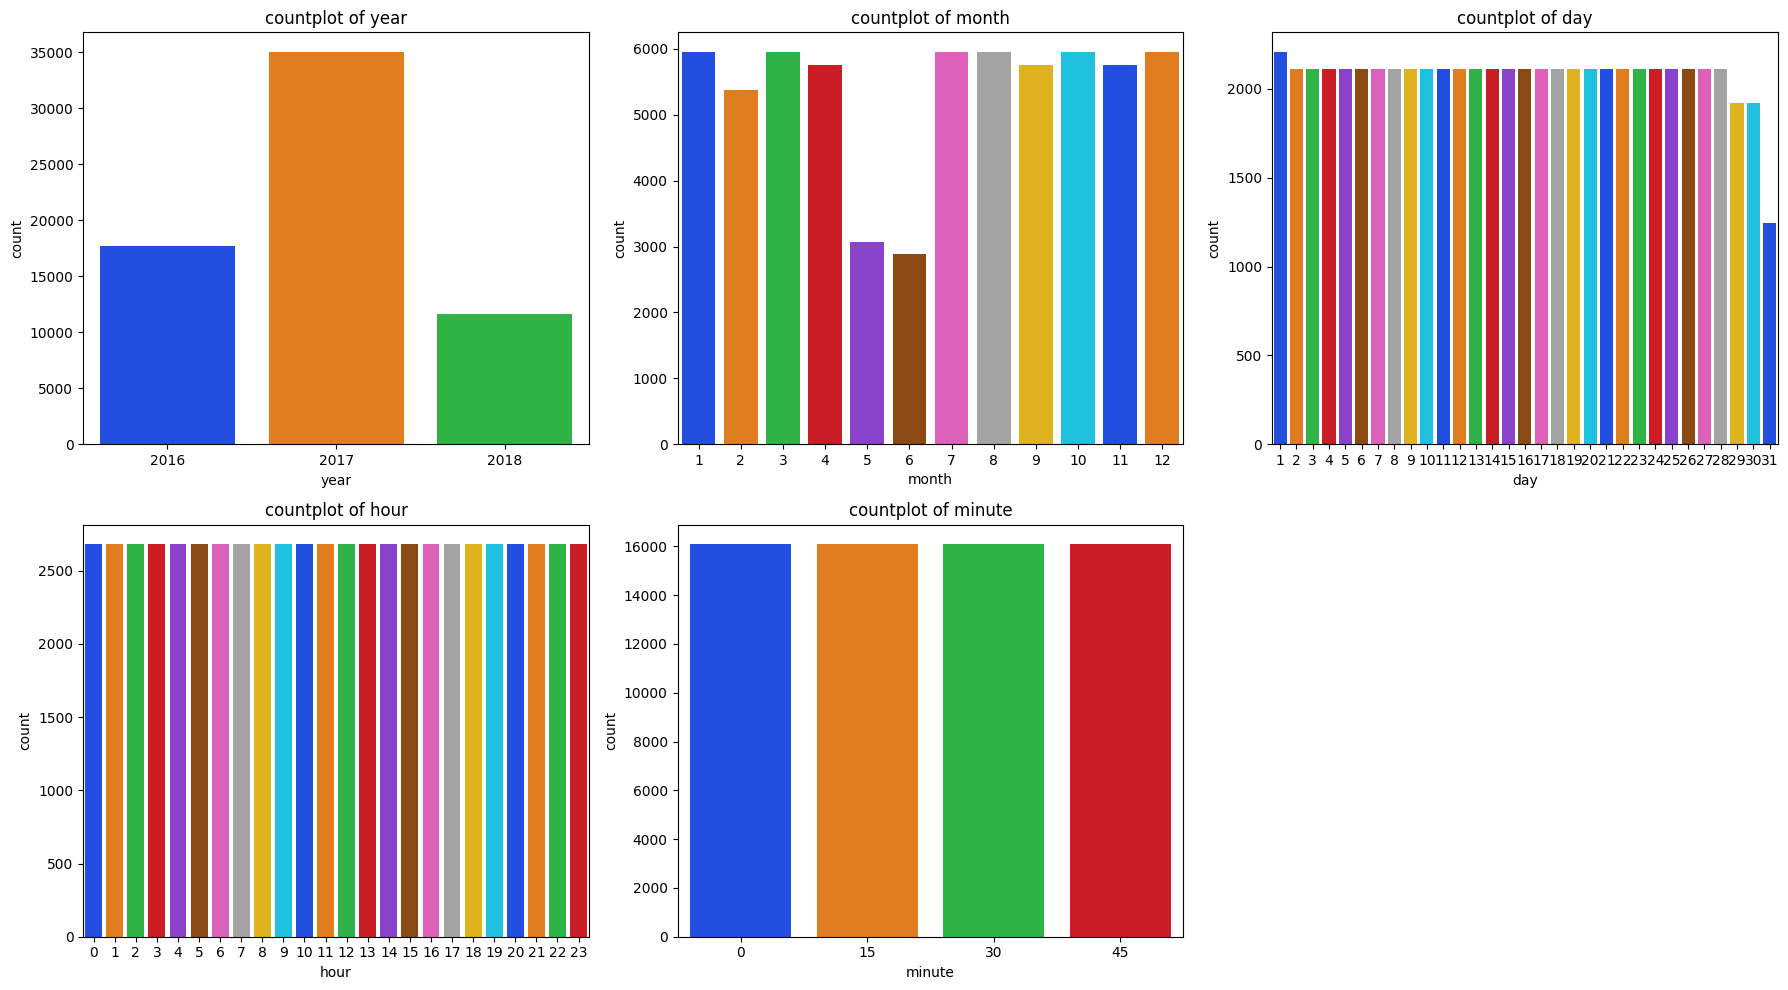

In [26]:
columns = [col for col in df.columns if col in int_columns] 
# TR = (in df.columns) df DataFrame içindeki (col for col)her sütuna bak.
# TR = (if col in int_columns) istenilen kolonlara bakar.

# EN = (in df.columns) Look at each column in df DataFrame (col for col).
# EN = (if col in int_columns) looks at the desired columns.

num_columns = len(columns)
# TR = sütun sayısını okuyup, num_columns değişkenine atadım.
# EN = I read the number of columns and assigned it to the num_columns variable.

fig, axes = plt.subplots(nrows=(num_columns // 3) + 1, ncols=3, figsize=(18, (num_columns // 3 + 1) * 5))
# TR = nrows=(num_columns // 3) + 1: Bu, oluşturulacak alt grafiklerin (subplot'ların) satır sayısını belirler.
# TR = num_columns // 3, toplam sütun sayısının 3'e bölünmesiyle elde edilen tam sayı değerdir. + 1 ise, sütun sayısı 3'e tam bölünmüyorsa ekstra bir satır ekler.
# TR = ncols=3: Bu, her satırda kaç tane alt grafik olacağını belirler. Bu örnekte, her satırda 3 alt grafik olacak şekilde ayarlanmıştır.  
# TR = figsize=(18, (num_columns // 3 + 1) * 5): Bu, oluşturulacak figürün (grafiklerin tümünün bulunduğu büyük alanın) boyutlarını ayarlar.
# TR = figsize parametresi, genişlik ve yükseklik değerlerini (18, (num_columns // 3 + 1) * 5) şeklinde alır. 
# TR = Genişlik 18 inç, yükseklik ise her satır için 5 inç olacak şekilde hesaplanır.

# EN = nrows=(num_columns // 3) + 1: This determines the number of rows of subplots to be created.
# EN = num_columns // 3 is the integer value obtained by dividing the total number of columns by 3. + 1 adds an extra row if the column count is not perfectly divisible by 3.
# EN = ncols=3: This determines how many subplots will be in each row. In this example, there will be 3 subplots per row.
# EN = figsize=(18, (num_columns // 3 + 1) * 5): This sets the size of the figure (the large area containing all the plots).
# EN = The figsize parameter takes the width and height values as (18, (num_columns // 3 + 1) * 5).
# EN = The width is 18 inches, and the height is calculated as 5 inches per row.


for i, column in enumerate(columns):  
    row = i // 3  
    # TR = Her sütunun hangi satırda gösterileceğini hesaplar (3 sütundan birinde)  
    # EN = Calculates which row each column should be displayed in (one of three columns)

    col = i % 3  
    # TR = Her sütunun hangi sütunda gösterileceğini hesaplar (0'dan 2'ye kadar)  
    # EN = Calculates which column each plot should be placed in (from 0 to 2)

    sns.countplot(data=df, x=column, ax=axes[row, col],palette='bright')
    # TR = Kategorik verilerin her bir sınıfındaki gözlem sayısını görselleştirmek için kullanılır ve her kategorinin frekansını çubuklarla gösterir.
    # EN = It is used to visualize the number of observations in each class of categorical data and shows the frequency of each category with bars.

    # TR = (data=df) Veriyi df adlı DataFrame alacak.
    # TR = (x=column) column değişkenindeki sütunları alıp yatay eksenine eşitleyecek
    # TR = (ax=axes[row, col]) Tablonun yukarıdan ve soldan kaçıncı sırada duracağını beliler

    # EN = (data=df) Will take the data from the DataFrame named df.
    # EN = (x=column) Will take the columns in the column variable and assign them to the x-axi
    # EN = (ax=axes[row, col]) Specifies the position in the grid, indicating which row and column it will be placed in.

    axes[row, col].set_title(f'countplot of {column}')  
    # TR = Grafiğin başlığını, ilgili sütun adı ile ayarlar  
    # EN = Sets the title of the plot to the name of the column

    axs = axs.flatten() if num_plots > 1 else [axs]  
    # TR = Grafik pencerelerini düzleştirir (eğer tek değilse)  
    # EN = Flattens the plot axes (if there’s more than one)


for j in range(i+1, len(axes.flat)):  
    # TR = Kullanılmayan alt grafikler (subplots) siliniyor  
    # EN = Removing unused subplots

    fig.delaxes(axes.flat[j])  
    # TR = Belirtilen alt grafiği (subplot) siler  
    # EN = Deletes the specified subplot from the figure

plt.tight_layout()  
# TR = Grafiklerin düzenli görünmesi için yerleşim ayarlarını yapar  
# EN = Adjusts the layout for a tidy appearance

plt.show()  
# TR = Grafiği ekranda gösterir  
# EN = Displays the plot on the screen

In [27]:
df.head(1)

,date,feature_AA,feature_AB,feature_BA,feature_BB,feature_CA,feature_CB,Temperature,year,month,day,hour,minute
0,2016-07-01,5.827,2.009,1.599,0.462,4.203,1.34,30.531,2016,7,1,0,0


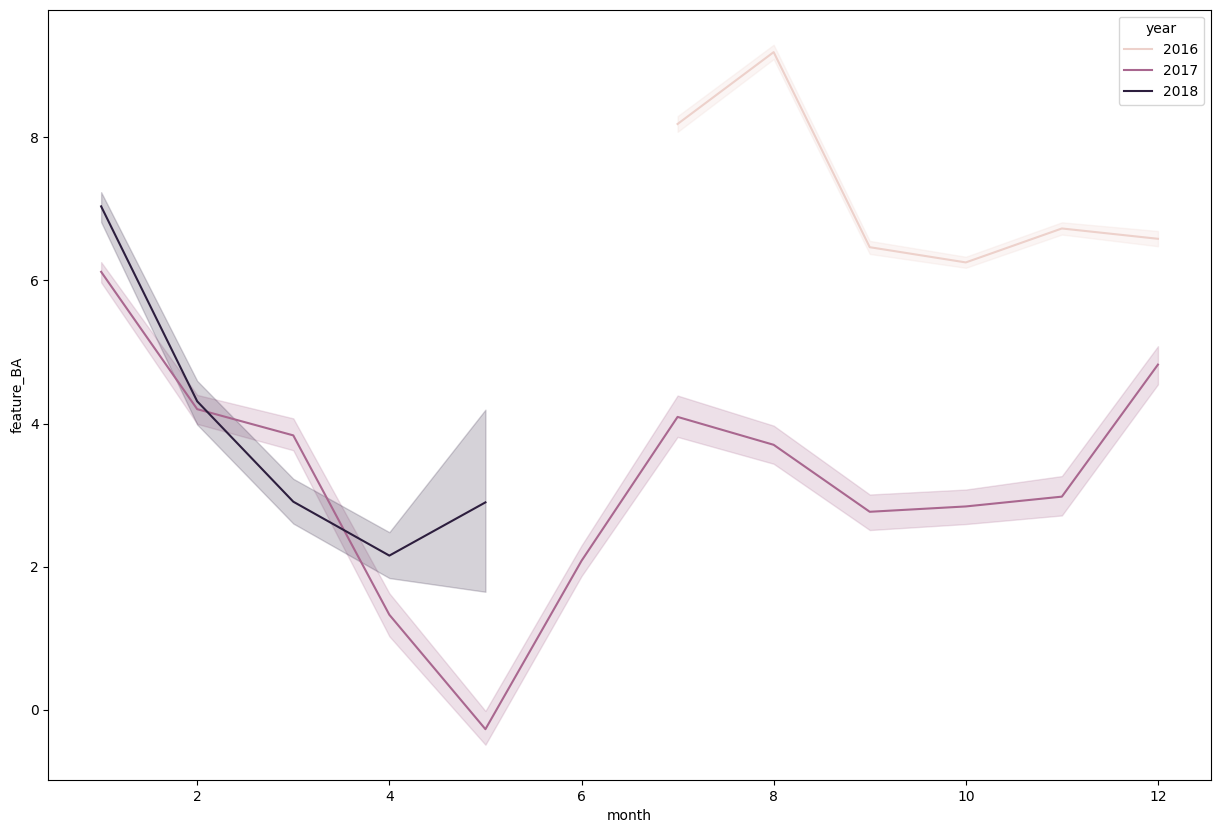

In [28]:
plt.figure(figsize=(15,10))
sns.lineplot(df,x='month',y='feature_BA',hue='year');

## <font color=#8810c4> Geleceği Tahmin Etme - Predicting the Future

In [29]:
forecast_data = df.reset_index().rename(columns={'date': 'ds', 'Temperature': 'y'})
# TR = DataFrame'in indeksini sıfırlayarak 'date' sütununu 'ds' ve 'Temperature' sütununu 'y' olarak yeniden adlandırır
# EN = Resets the DataFrame index and renames the 'date' column to 'ds' and the 'Temperature' column to 'y'

model = Prophet()
# TR = Prophet modelini oluşturur
# EN = Creates a Prophet model

model.fit(forecast_data)
# TR = Prophet modelini, hazırlanan verilerle eğitir
# EN = Fits the Prophet model with the prepared data

forecasts = model.make_future_dataframe(periods=720)
# TR = Gelecekteki 720 gün için tarihleri içeren bir DataFrame oluşturur
# EN = Creates a DataFrame containing future dates for the next 720 days

predictions = model.predict(forecasts)
# TR = Gelecek tarih aralığı için tahminleri hesaplar
# EN = Calculates predictions for the future date range

fig1 = plot_plotly(model, predictions)
# TR = Prophet tahminlerinin ana grafik görünümünü oluşturur
# EN = Creates the main plot view of Prophet predictions

fig2 = plot_components_plotly(model, predictions)
# TR = Prophet modelinin bileşen grafiğini oluşturur (trend, mevsimsellik vb.)
# EN = Creates the component plot of the Prophet model (trend, seasonality, etc.)

fig1.show()
# TR = Tahmin grafiğini görüntüler
# EN = Displays the forecast plot

fig2.show()
# TR = Bileşen grafiğini görüntüler
# EN = Displays the component plot


15:36:07 - cmdstanpy - INFO - Chain [1] start processing
15:36:53 - cmdstanpy - INFO - Chain [1] done processing


MemoryError: Unable to allocate 496. MiB for an array with shape (1000, 65040) and data type float64

## <font color='#0F52BA'> Öznitelik Mühendisliği - Feature Engineering

### <font color=#007fff> Model - Modelling 

In [ ]:
abs(df.corr(numeric_only=True)['Temperature']).sort_values(ascending=False)

In [ ]:
x=df.drop(['Temperature','hour','day','minute','date'],axis=1)
y=df[['Temperature']]

In [ ]:
x=pd.get_dummies(x,drop_first=True) 
# TR =  kategorik değişkenlerin sayısal değişkenlere dönüştürülmesi için kullanılır. 
# En = It is used to convert categorical variables into numerical variables.

In [ ]:
x_train,x_test,y_train,y_test=train_test_split(x,y,test_size=.20,random_state=42)
# TR = modelimizi eğittik. 
# EN = We trained our model.

In [ ]:
scaler = StandardScaler()
# TR = Avantajları:
# TR = Negatif ve pozitif değerler içeren verilerde performansı artırabilir.
# TR = Aykırı değerlere karşı daha dayanıklıdır.
# TR = Dezavantajları:
# TR = Veriyi kesin bir aralığa sığdırmaz (örneğin, 0 ile 1 arasında).

# EN = Advantages:
# EN = Can improve performance for data containing both negative and positive values.
# EN = More robust to outliers.
# EN = Disadvantages:
# EN = Does not fit the data into a specific range (e.g., between 0 and 1).

x_train = scaler.fit_transform(x_train)
# TR = Verileri ölçekleyerek, modelin daha hızlı ve etkili öğrenmesini sağlamak için tüm özellikleri aynı aralığa getiriyoruz.
# EN = By scaling the data, we bring all the features into the same range to allow the model to learn faster and more effectively.

x_test = scaler.transform(x_test)
# TR = Test verilerini eğitimde kullanılan aynı ölçekle dönüştürerek modelin test verileri üzerinde doğru tahminler yapmasını sağlar.
# EN = It enables the model to make accurate predictions on the test data by transforming the test data to the same scale used in training.

In [ ]:
model=Sequential()
model.add(Dense(256,activation='relu',input_dim=x_train.shape[1]))
# TR = Bu katman, tüm giriş nöronlarına bağlantı kurar ve her nöronun ağırlıklarını öğrenir. 256 nöron var.
# TR = Aktivasyon fonksiyonunu ReLU (Rectified Linear Unit) olarak ayarlar. ReLU fonksiyonu, negatif değerleri sıfıra dönüştürür ve pozitif değerleri olduğu gibi bırakır.

# EN = This layer connects all input neurons and learns the weights of each neuron. There are 256 neurons.
# EN = Sets the activation function to ReLU (Rectified Linear Unit). The ReLU function converts negative values ​​to zero and leaves positive values ​​as is.

model.add(Dense(128,activation='relu'))
model.add(Dense(64,activation='relu'))
model.add(Dense(32,activation='relu'))
model.add(Dense(1, activation='linear'))
# TR = Regresyon görevleri için lineer aktivasyon kullanıyoruz.
# EN = We use linear activation for regression tasks. 

model.compile(loss='mse', optimizer='adam', metrics=['mae'])  
# TR = Modelin kayıp fonksiyonu olarak 'mse' (ortalama kare hatası), optimizer olarak 'adam' ve performans metriği olarak 'mae' (ortalama mutlak hata) kullanılarak derlenmesini sağlar  
# EN = Compiles the model using 'mse' (mean squared error) as the loss function, 'adam' as the optimizer, and 'mae' (mean absolute error) as the performance metric

early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)
# TR = EarlyStopping ekleyin: Eğitim sırasında model performansı iyileşmediğinde erken durması için kullanıyoruz.
# EN = Add EarlyStopping: We use it to stop early when model performance does not improve during training.

# TR = val_loss 10 epoch boyunca iyileşmezse eğitimi durduruyor ve en iyi ağırlıkları geri yüklüyor.
# EN = If val_loss does not improve for 10 epochs, it stops training and restores the best weights.

history=model.fit(x_train, y_train, validation_data=(x_test, y_test), batch_size=128, epochs=100, callbacks=[early_stopping])
# TR = Modeli 100 epoch boyunca eğitiyoruz, fakat EarlyStopping ile durdurulabilir. Batch boyutu 128 olarak belirlenmiş.
# EN = We train the model for 100 epochs, but it can be stopped with EarlyStopping. Batch size is set to 128.

In [ ]:
model.summary()

In [ ]:
test_loss, test_acc = model.evaluate(x_test, y_test)
# TR = test_loss değişkeni, test verileri üzerinde hesaplanan kayıp değerini içerir. test_acc değişkeni, test verileri üzerinde hesaplanan doğruluk değerini içerir.
# EN = The test_loss variable contains the loss value calculated on the test data. The test_acc variable contains the accuracy value calculated on the test data.

print(f"Test doğruluğu: {test_acc:.4f}")

In [ ]:
pred=model.predict(x_test)
# TR = modeli x_test ile predict özelliği ile tahmin ettik. predict=tahmin demek. Dahmin edip pred eşitledik. 
# EN = We predicted the model with x_test and the predict feature. predict=means prediction. We guessed and equalized the pred.

In [ ]:
r2_score(y_test,pred) 
# TR = Bunu gerçek(y_test) değer ile tahmin(pred) edilen değerleri karşılaştır ve arasındaki farkı bul. 
# EN = Compare this with the actual (y_test) value and the predicted (pred) values ​​and find the difference between them.

In [ ]:
mean_squared_error(y_test,pred)**.5 
# TR = Burada, Root Mean Square Error bulduk. Bunu gerçek(y_test) değer ile tahmin(pred) edilen değerleri karşılaştır arasındaki farkı bul ve **.5 ile karekökünü al.
# EN = Here, we found Root Mean Square Error. Compare this with the actual (y_test) value and the predicted (pred) values, find the difference and take the square root of **.5.

In [ ]:
mean_absolute_error(y_test,pred)
# TR = mean_absolute_error ile (y_test,pred) kullanarak değerini hesaplama. 
# EN = Calculating the value of mean_absolute_error using (y_test,pred).

In [ ]:
residuals=y_test-pred

In [ ]:
sns.kdeplot(x=residuals['Temperature'],fill=True);
# TR = Veri dağılımını pürüzsüz bir şekilde tahmin etmek için kullanılan bir yoğunluk grafiğidir. Kernel Yoğunluk Tahmini (KDE) ile verinin altında yatan olasılık dağılımını görselleştirir.
# EN = It is a density plot used to smoothly estimate the distribution of data. It visualizes the underlying probability distribution of data using Kernel Density Estimation (KDE).

In [ ]:
loss_f=pd.DataFrame(history.history)

In [ ]:
loss_f.plot();

In [ ]:
pickle.dump(model,open('Sıcaklık.pkl','wb'))